In [1]:
#import necessary libraries
import tensorflow as tf
import bayesflow as bf
import numpy as np
import json

/Users/masonyoungblood/anaconda3/envs/bayesflow/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
#load in training data and format
with open("data_and_output/01_all_params/train_data.json") as f:
    l = json.load(f)
train_data = {}
train_data["prior_non_batchable_context"] = None
train_data["prior_batchable_context"] = None
train_data["prior_draws"] = np.array(l[0], dtype = float)
train_data["sim_non_batchable_context"] = None
train_data["sim_batchable_context"] = None
train_data["sim_data"] = np.array(l[1], dtype = float)

#load in testing data and format
with open("data_and_output/01_all_params/test_data.json") as f:
    l = json.load(f)
test_data = {}
test_data["prior_non_batchable_context"] = None
test_data["prior_batchable_context"] = None
test_data["prior_draws"] = np.array(l[0], dtype = float)
test_data["sim_non_batchable_context"] = None
test_data["sim_batchable_context"] = None
test_data["sim_data"] = np.array(l[1], dtype = float)

In [3]:
#set number of parameters, epochs, batch size, and learning rate
num_params = 15
epochs = 100
batch_size = 32
learning_rate = 0.0005

In [4]:
#initialize summary network, inference network, and amortized posterior
#default settings live here: https://github.com/stefanradev93/BayesFlow/blob/master/bayesflow/default_settings.py
summary_net = bf.networks.TimeSeriesTransformer(input_dim = 380, num_dense_fc = 4, summary_dim = 256, dense_settings = {"units": 512, "activation": "relu"}, template_type = "gru")
inference_net = bf.networks.InvertibleNetwork(num_params = num_params, num_coupling_layers = 10, coupling_design = "affine", coupling_settings = {"dropout_prob": 0.05, "num_dense": 4, "dense_args": {"units": 128, "activation": "relu"}})
amortized_posterior = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

In [5]:
#create trainer
trainer = bf.trainers.Trainer(amortizer = amortized_posterior, default_lr = learning_rate, memory = True, checkpoint_path = "data_and_output/02_all_params_check/checkpoints")

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Initialized empty loss history.
INFO:root:Initialized empty simulation memory.
INFO:root:Initialized networks from scratch.


In [6]:
#setup custom optimizer that runs faster on apple silicon
#adapted from _setup_optimizer and train_offline in trainers.py, and defaults in OPTIMIZER_DEFAULTS in default_settings.py
schedule = tf.keras.optimizers.schedules.CosineDecay(learning_rate, epochs*bf.trainers.SimulationDataset(train_data, batch_size).num_batches, name = "lr_decay")
optimizer = tf.keras.optimizers.legacy.Adam(schedule, global_clipnorm = 1)

In [7]:
#run training and save
history = trainer.train_offline(simulations_dict = train_data, epochs = epochs, batch_size = batch_size, optimizer = optimizer)
trainer._save_trainer("data_and_output/02_all_params_check/model")

Training epoch 100: 100%|██████████| 282/282 [00:26<00:00, 10.84it/s, Epoch: 100, Batch: 282,Loss: 2.968,W.Decay: 0.744,Avg.Loss: 4.114,Avg.W.Decay: 0.744,LR: 0.00E+00]


In [8]:
#load trained network
trainer.load_pretrained_network()

In [9]:
#sample 100 posterior draws per simulation run in the test set
test_set = trainer.configurator(test_data)
test_posteriors = amortized_posterior.sample(test_set, n_samples = 100)

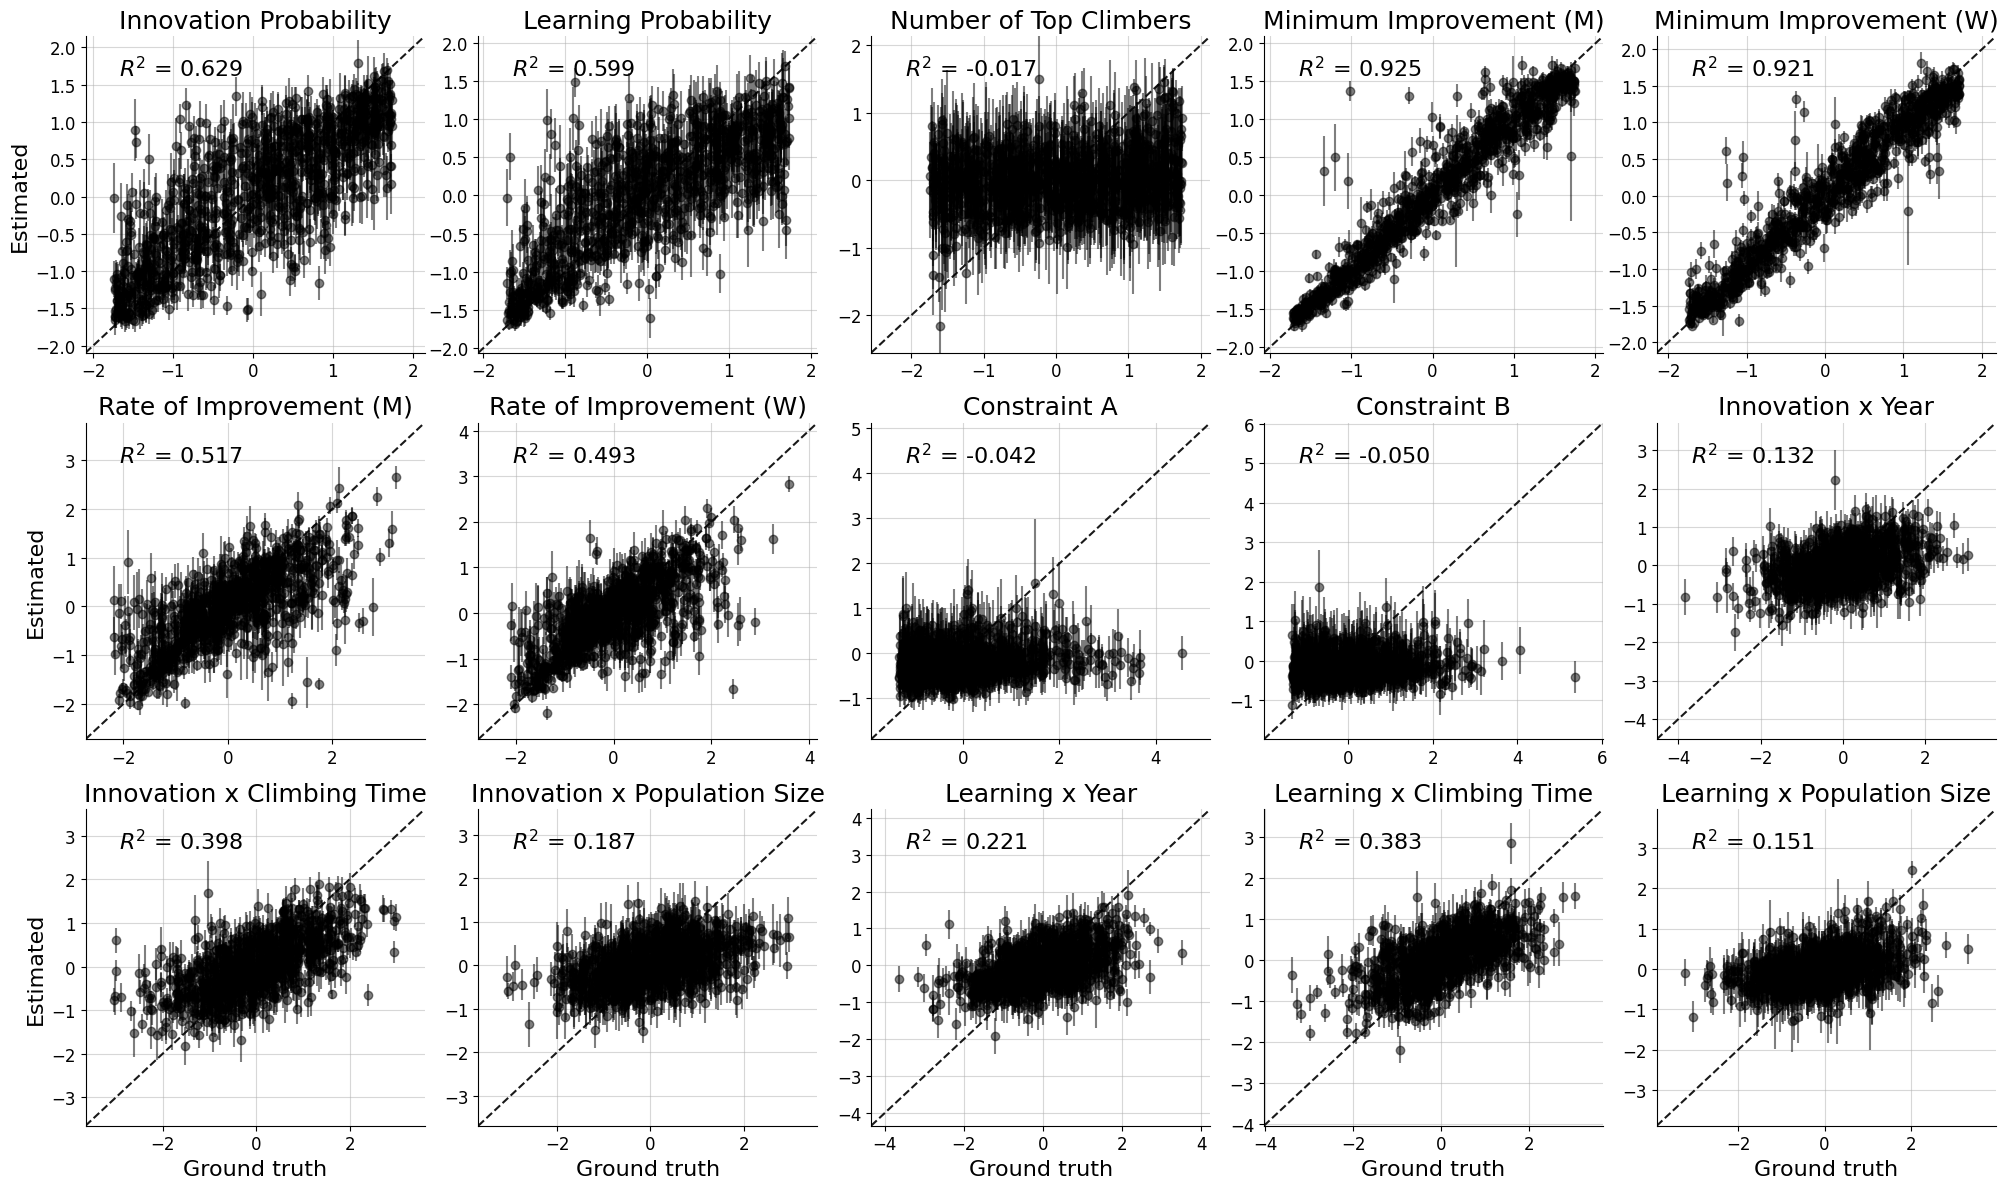

In [10]:
#plot recovery of parameter values
recovery_plot = bf.diagnostics.plot_recovery(test_posteriors, test_set["parameters"],
                                             param_names = ["Innovation Probability", "Learning Probability", "Number of Top Climbers",
                                                            "Minimum Improvement (M)", "Minimum Improvement (W)",
                                                            "Rate of Improvement (M)", "Rate of Improvement (W)",
                                                            "Constraint A", "Constraint B",
                                                            "Innovation x Year", "Innovation x Climbing Time", "Innovation x Population Size",
                                                            "Learning x Year", "Learning x Climbing Time", "Learning x Population Size"], color = "black", add_corr = False)
recovery_plot.savefig("data_and_output/02_all_params_check/recovery_plot.pdf")